In [1]:
import pandas as pd
import numpy as np
import glob
import os
import seaborn as sns
import cmocean as cmo
import matplotlib.pyplot as plt

In [2]:
path = '../../data'
on_topic_file = f'{path}/conversation_to_topic.txt'
twitter_stats_file = f'{path}/twitter/twitter_statistics.txt'
reddit_stats_file = f'{path}/reddit/reddit_statistics.txt'
handcoded_file = f'{path}/handcoded/handcoded.txt'

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Load data

In [4]:
twitter = pd.read_csv(twitter_stats_file, sep='\t',
                      dtype={'conversation_id':str})
reddit = pd.read_csv(reddit_stats_file, sep='\t')

print(f'Stats for {len(twitter)} Twitter conversations loaded')
print(f'Stats for {len(reddit)} Reddit conversations loaded')

Stats for 113966 Twitter conversations loaded
Stats for 118307 Reddit conversations loaded


In [5]:
# handcoded data
coded = pd.read_csv(handcoded_file, sep='\t')

t_sampled = coded.merge(twitter, on='conversation_id', how='inner')
r_sampled = coded.merge(reddit, on='conversation_id', how='inner')

print(f'{len(t_sampled)} Twitter conversations sampled')
print(f'{len(r_sampled)} Twitter conversations sampled')


209 Twitter conversations sampled
297 Twitter conversations sampled


In [6]:
classified = pd.read_csv(on_topic_file,sep='\t')
t_class = classified.merge(twitter,  on='conversation_id', how='inner')
r_class = classified.merge(reddit,  on='conversation_id', how='inner')

print(f'{len(classified)} total conversations classified')
print(f'{len(t_class)} Twitter conversations classified')
print(f'{len(r_class)} Reddit conversations classified')

207630 total conversations classified
92854 Twitter conversations classified
114775 Reddit conversations classified


In [7]:
def get_heatmap(df, topic):
    if topic == 'all':
        sub = df.dropna(subset=['new_topic_spread', 'tox_mean'])
    else:
        sub = df[df['classified_topic'] == topic][['new_topic_spread', 'tox_mean']].dropna()

    #bounds = np.arange(-0.05, 1.15, .1)
    bounds = np.arange(0, 1.1, .1)
    n = len(bounds) - 1

    matrix = np.zeros((n, n))
    bottom_top = bounds[0]

    for i, top_val in enumerate(bounds[1:]):
        top_val = np.around(top_val, 2)
        bottom_tox = bounds[0]

        for j, tox_val in enumerate(bounds[1:]):
            tox_val = np.around(tox_val, 2)

            count = len(sub[(sub.tox_mean<tox_val) 
                            & (sub.tox_mean>=bottom_tox) 
                            & (sub.new_topic_spread<top_val) 
                            & (sub.new_topic_spread>=bottom_top)])

            matrix[i][j] = count

            bottom_tox = tox_val

        bottom_top = top_val

    matrix = matrix / np.sum(matrix)
    
    return matrix

# Heatmaps -- On topic data

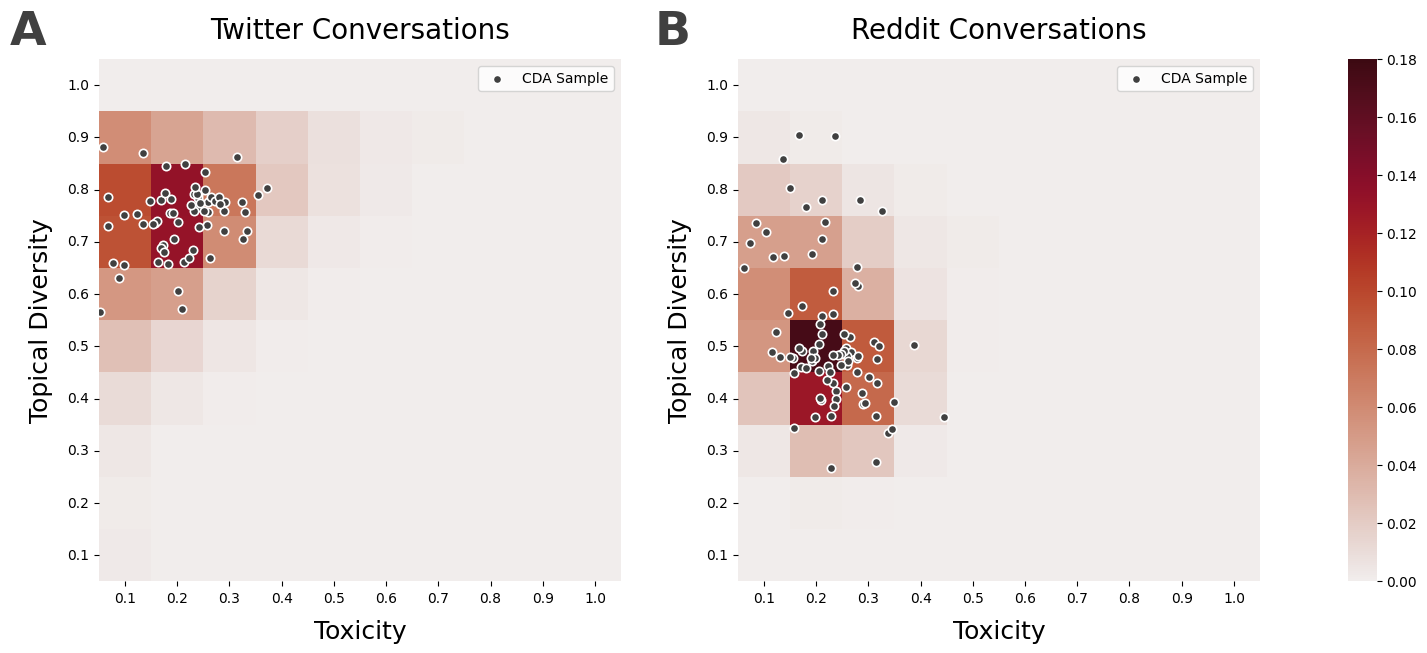

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1,ncols=3,
                                    figsize=(14,6),
                                   gridspec_kw={
                                   'width_ratios': [6, 6, .3] #,
                                   #'wspace':.18
                               })

# Twitter
matrix = get_heatmap(t_class, 'all')

bounds = np.arange(.1, 1.1, .1)

sns.heatmap(matrix,
            cmap=cmo.cm.amp,
            square=True,
            xticklabels=np.around(bounds, 1),
            yticklabels=np.around(bounds, 1),
            ax=ax1,
            cbar=False,
            vmax=0.18)
ax1.invert_yaxis()
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)

# handcoded
t = t_sampled[t_sampled['final_on_topic']=='Yes']
x = t.tox_mean.values
y = t.new_topic_spread.values
ax1.scatter(x*10, y*10, color='#404040',
            edgecolors='white',
            linewidths=1.2,
            label='CDA Sample')

ax1.set_xlabel('Toxicity', fontsize=18, labelpad=10)
ax1.set_ylabel('Topical Diversity', fontsize=18, labelpad=10)
ax1.set_title(f'Twitter Conversations', fontsize=20, pad=15)
ax1.legend()
ax1.text(-0.1, 1.095, 'A', transform=ax1.transAxes,
      fontsize=34, fontweight='bold', color='#404040', 
         va='top', ha='right')

# Reddit
matrix = get_heatmap(r_class, 'all')
    
ax2 = sns.heatmap(matrix,
                  cmap=cmo.cm.amp,
                  square=True,
                  xticklabels=np.around(bounds, 1),
                  yticklabels=np.around(bounds, 1),
                  ax=ax2,
                  cbar_ax=ax3,
                  vmax=0.18)

ax2.invert_yaxis()
ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0)


# hand coded
r = r_sampled[r_sampled['final_on_topic']=='Yes']
x = r.tox_mean.values
y = r.new_topic_spread.values
ax2.scatter(x*10, y*10, color='#404040', 
            edgecolors='white',
            label='CDA Sample',
            linewidths=1.2)

ax2.legend()

ax2.set_xlabel('Toxicity', fontsize=18, labelpad=10)
ax2.set_ylabel('Topical Diversity', fontsize=18, labelpad=10)
ax2.set_title(f'Reddit Conversations', fontsize=20, pad=15)
ax2.text(-0.09, 1.095, 'B', transform=ax2.transAxes,
      fontsize=34, fontweight='bold', color='#404040', 
         va='top', ha='right')

fig.tight_layout(pad=-1)
plt.savefig('figs/heatmaps.png', dpi=300,
             bbox_inches='tight')
fig.show()

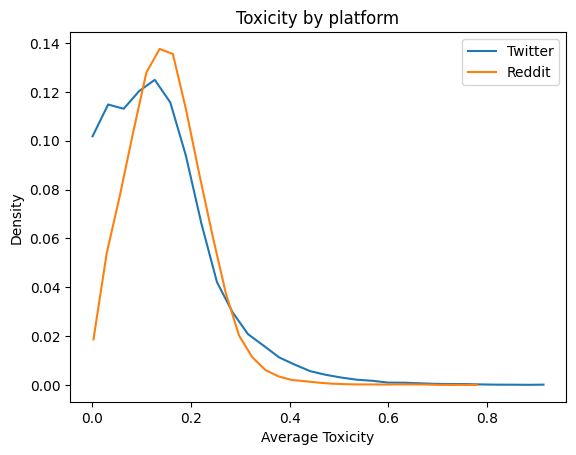

In [9]:
# Reddit
vals = r_class['tox_mean'].dropna()

r_y, r_bins = np.histogram(vals,
                           weights=np.ones(len(vals))/len(vals), 
                           bins=30)

# Twitter
vals = t_class['tox_mean'].dropna()

t_y, t_bins = np.histogram(vals,
                           weights=np.ones(len(vals))/len(vals), 
                           bins=30)

plt.plot(t_bins[:-1], t_y, label='Twitter')
plt.plot(r_bins[:-1], r_y, label='Reddit')

plt.legend()

plt.xlabel('Average Toxicity')
plt.ylabel('Density')

plt.title('Toxicity by platform')
         
plt.show()

### By topic and platform

In [10]:
topics = ['US midterm elections', 'Russia/Ukraine war', 'Childcare/parenting']

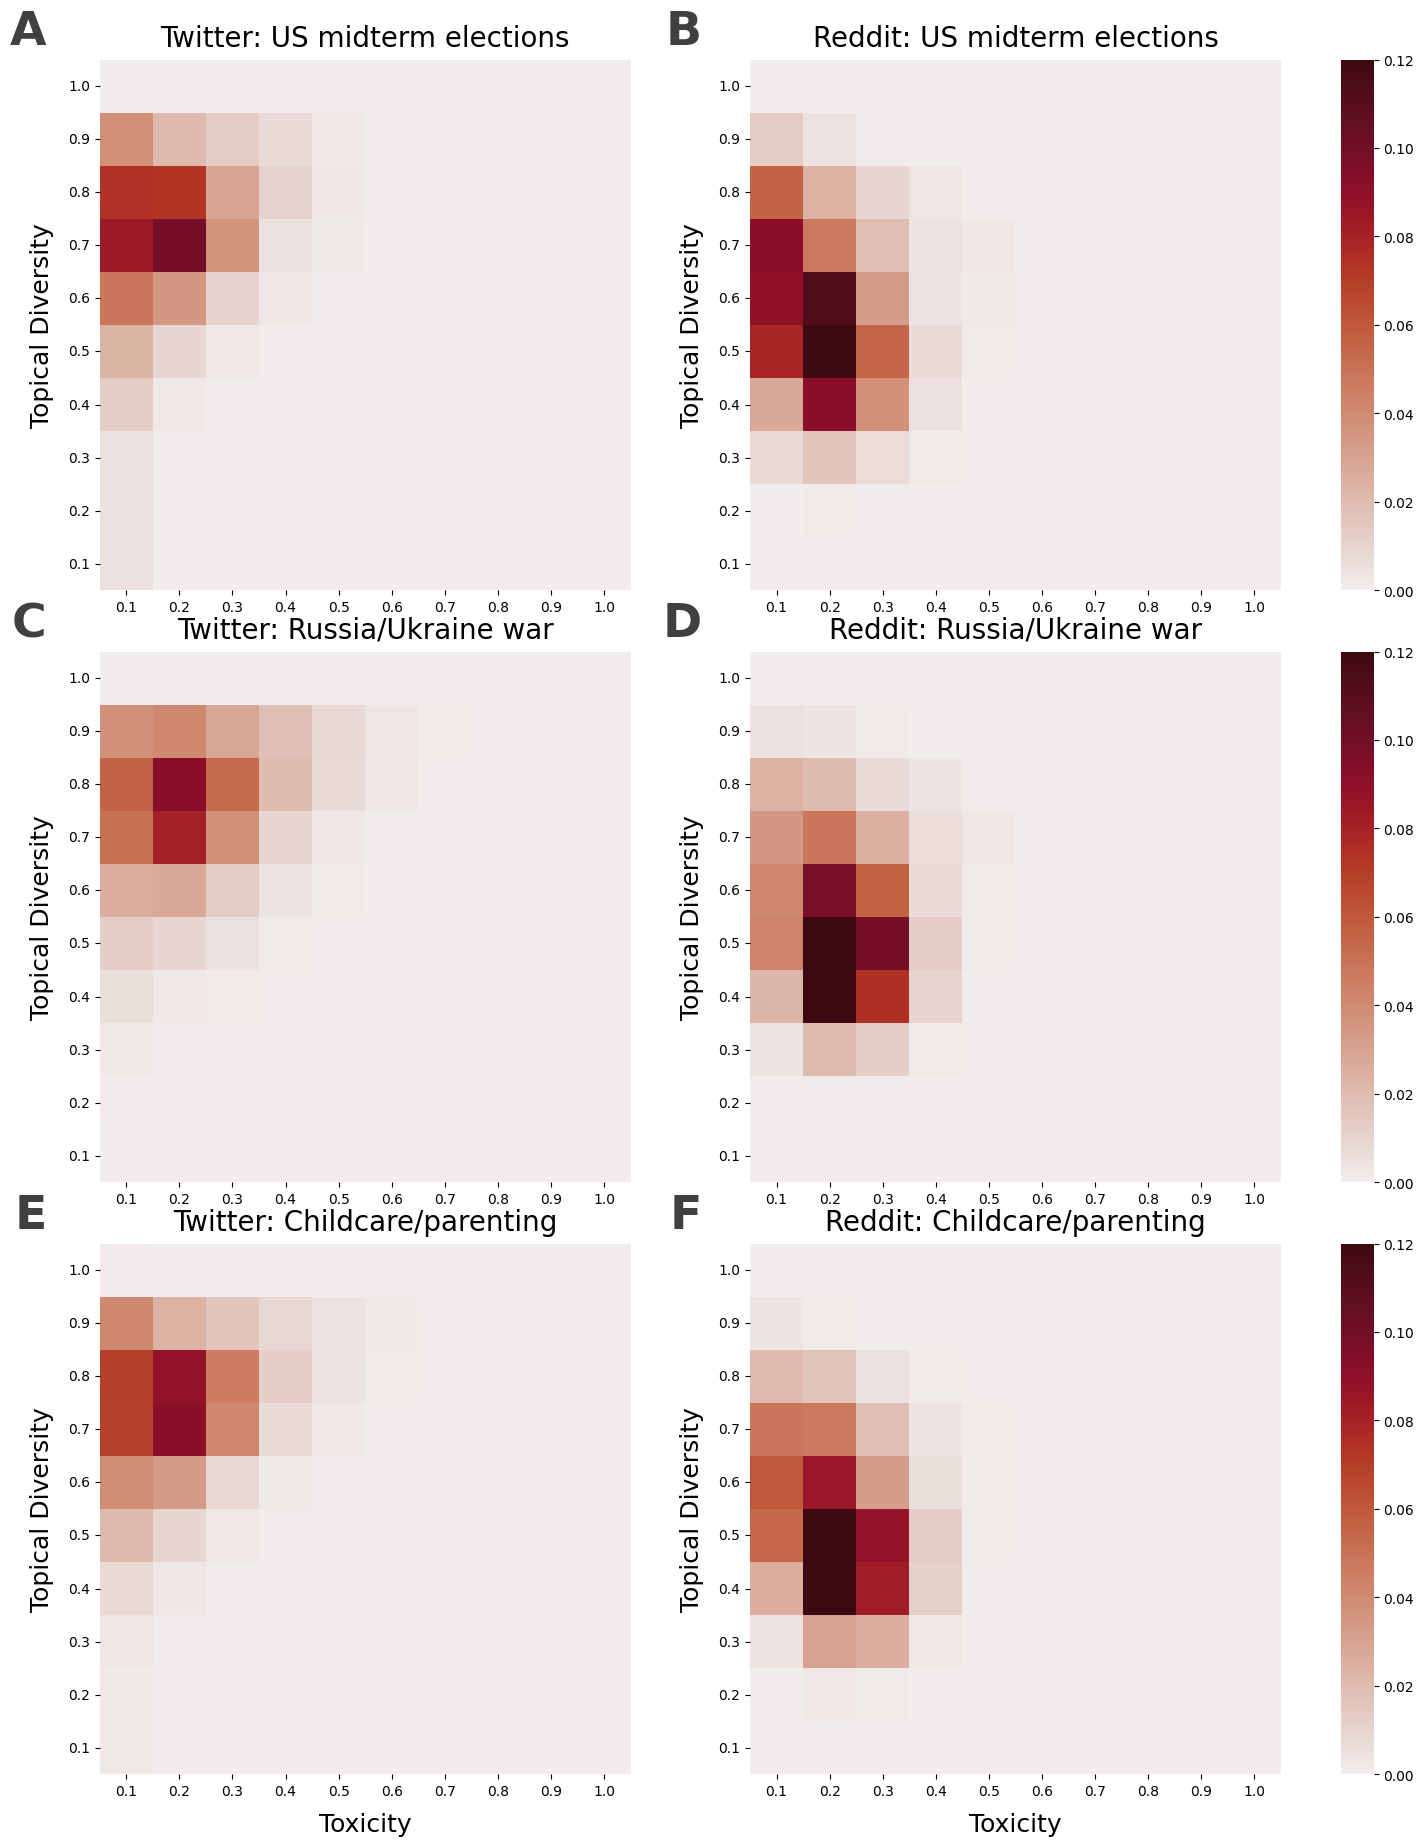

In [11]:
fig, ax = plt.subplots(nrows=3, ncols=3,
                        figsize=(14,18),
                        gridspec_kw={
                       'width_ratios': [6, 6, .3] #,
                       #'wspace':.18
                   })

for i, topic in enumerate(topics):
    # Twitter
    matrix = get_heatmap(t_class, topic)

    bounds = np.arange(.1, 1.1, .1)

    sns.heatmap(matrix,
                     cmap=cmo.cm.amp,
                     square=True,
                     xticklabels=np.around(bounds, 1),
                     yticklabels=np.around(bounds, 1),
                     ax=ax[i][0],
                     cbar=False,
                     vmax=0.18)
    
    ax[i][0].invert_yaxis()
    ax[i][0].set_yticklabels(ax[i][0].get_yticklabels(), rotation=0)


    if i == 2:
        ax[i][0].set_xlabel('Toxicity', fontsize=18, labelpad=10)
        
    ax[i][0].set_ylabel('Topical Diversity', fontsize=18, labelpad=10)
    ax[i][0].set_title(f'Twitter: {topic}', fontsize=20, pad=10)
    
    letters = {0:'A',
               1:'C',
               2:'E'}
    
    ax[i][0].text(-0.1, 1.095, letters[i], transform=ax[i][0].transAxes,
          fontsize=34, fontweight='bold', color='#404040', 
             va='top', ha='right')

    # Reddit
    matrix = get_heatmap(r_class, topic)

    ax[i][1] = sns.heatmap(matrix,
                cmap=cmo.cm.amp,
                square=True,
                xticklabels=np.around(bounds, 1),
                yticklabels=np.around(bounds, 1),
                ax=ax[i][1],
                cbar_ax=ax[i][2],
                vmax=0.12)

    ax[i][1].invert_yaxis()
    ax[i][1].set_yticklabels(ax[i][1].get_yticklabels(), rotation=0)

    
    if i == 2:
        ax[i][1].set_xlabel('Toxicity', fontsize=18, labelpad=10)
    ax[i][1].set_ylabel('Topical Diversity', fontsize=18, labelpad=10)
    ax[i][1].set_title(f'Reddit: {topic}', fontsize=20, pad=10)
    
    letters = {0:'B',
           1:'D',
           2:'F'}
        
    ax[i][1].text(-0.09, 1.095, letters[i], transform=ax[i][1].transAxes,
          fontsize=34, fontweight='bold', color='#404040', 
             va='top', ha='right')

    fig.tight_layout(pad=-1)
    plt.savefig('figs/appendix_heatmaps_by_topic.png', dpi=300,
                 bbox_inches='tight')
    fig.show()

# Heatmaps -- All data

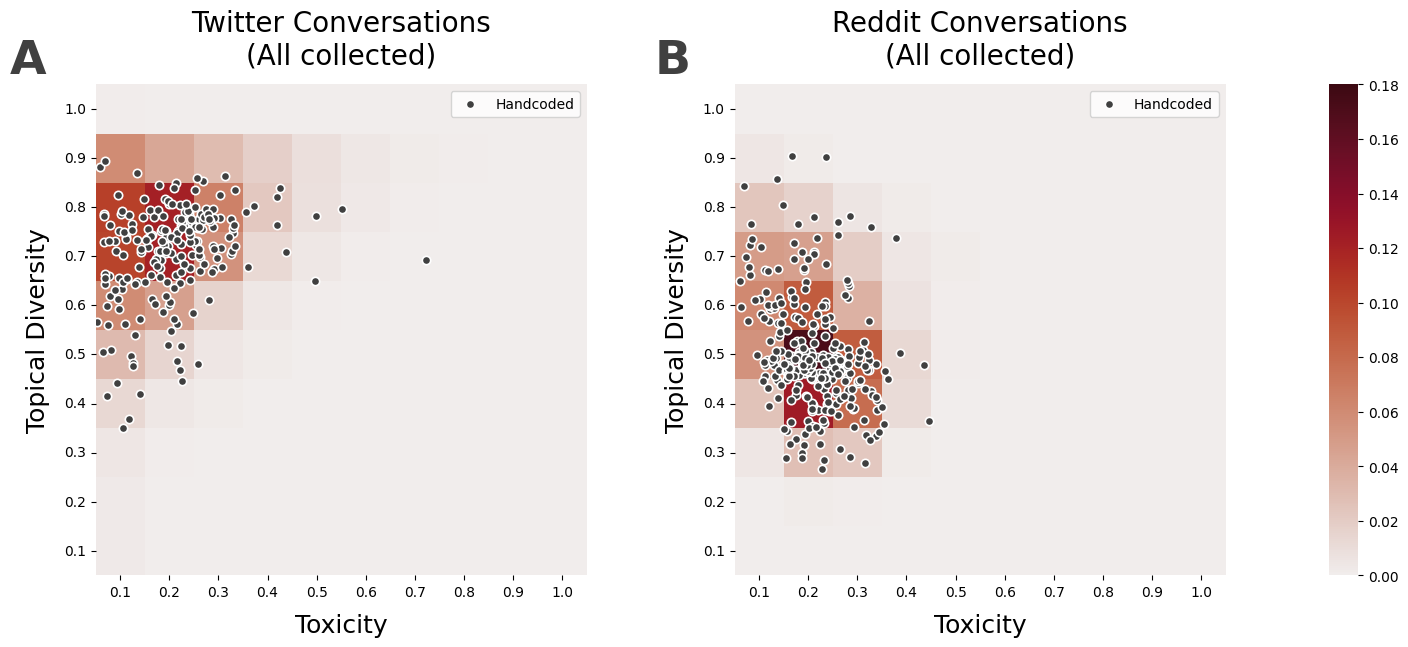

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1,ncols=3,
                                    figsize=(14,6),
                                   gridspec_kw={
                                   'width_ratios': [6, 6, .3] #,
                                   #'wspace':.18
                               })

# Twitter
matrix = get_heatmap(twitter, 'all')

bounds = np.arange(.1, 1.1, .1)

sns.heatmap(matrix,
            cmap=cmo.cm.amp,
            square=True,
            xticklabels=np.around(bounds, 1),
            yticklabels=np.around(bounds, 1),
            ax=ax1,
            cbar=False,
            vmax=0.18)
ax1.invert_yaxis()
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)

# handcoded
t = t_sampled
x = t.tox_mean.values
y = t.new_topic_spread.values
ax1.scatter(x*10, y*10, color='#404040',
            edgecolors='white',
            linewidths=1.2,
            label='Handcoded')

ax1.set_xlabel('Toxicity', fontsize=18, labelpad=10)
ax1.set_ylabel('Topical Diversity', fontsize=18, labelpad=10)
ax1.set_title(f'Twitter Conversations\n(All collected)', fontsize=20, pad=15)
ax1.legend()
ax1.text(-0.1, 1.095, 'A', transform=ax1.transAxes,
      fontsize=34, fontweight='bold', color='#404040', 
         va='top', ha='right')

# Reddit
matrix = get_heatmap(reddit, 'all')
    
ax2 = sns.heatmap(matrix,
                  cmap=cmo.cm.amp,
                  square=True,
                  xticklabels=np.around(bounds, 1),
                  yticklabels=np.around(bounds, 1),
                  ax=ax2,
                  cbar_ax=ax3,
                  vmax=0.18)

ax2.invert_yaxis()
ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0)


# hand coded
r = r_sampled
x = r.tox_mean.values
y = r.new_topic_spread.values
ax2.scatter(x*10, y*10, color='#404040', 
            edgecolors='white',
            label='Handcoded',
            linewidths=1.2)

ax2.legend()

ax2.set_xlabel('Toxicity', fontsize=18, labelpad=10)
ax2.set_ylabel('Topical Diversity', fontsize=18, labelpad=10)
ax2.set_title(f'Reddit Conversations\n(All collected)', fontsize=20, pad=15)
ax2.text(-0.09, 1.095, 'B', transform=ax2.transAxes,
      fontsize=34, fontweight='bold', color='#404040', 
         va='top', ha='right')

fig.tight_layout(pad=-1)
plt.savefig('figs/aapendix_heatmaps_all.png', dpi=300,
             bbox_inches='tight')
fig.show()

# Network stats

In [13]:
twitter_blue = '#1DA1F2'
reddit_orange = '#ff6314'

In [14]:
t_stats = t_class.copy()
r_stats = r_class.copy()

In [15]:
def drop_zeros(x, y):
    i = np.where(y!=0)
    keep_x = x[i]
    keep_y = y[i]
    
    return keep_x, keep_y

In [16]:
def binning(data,nb=50,log=True):
    # Seperate a vector of data into linear or log bins

    # Input:
    #   data : a vector of data
    #   bins : the number of bins to output (default: 50) 
    #   log : whether to log bin the data (default: True)

    # Output:
    #   x : the the midpoint of each bin
    #   y: the height of each bin 


    # 1. find the data's upper and lower bounds
    lower_bound = min(data)
    upper_bound = max(data) + 1

    # 2. Define bins
    if log:
        lower_bound = np.log10(lower_bound) if lower_bound > 0 else 0
        upper_bound = np.log10(upper_bound)
        bins = np.logspace(lower_bound, upper_bound, nb)

    else:
        bins = np.linspace(lower_bound, upper_bound, nb)
    
    # 3. Compute the midpoint of each bin
    x = bins[1:] - np.diff(bins) / 2.0 

    # 4. Compute the height of each bin
    y, __ = np.histogram(data, bins = bins, density=False)

    # fix numpy density issue
    y = y / np.sum(y)
    
    x, y = drop_zeros(x, y)

    return x, y

# All data

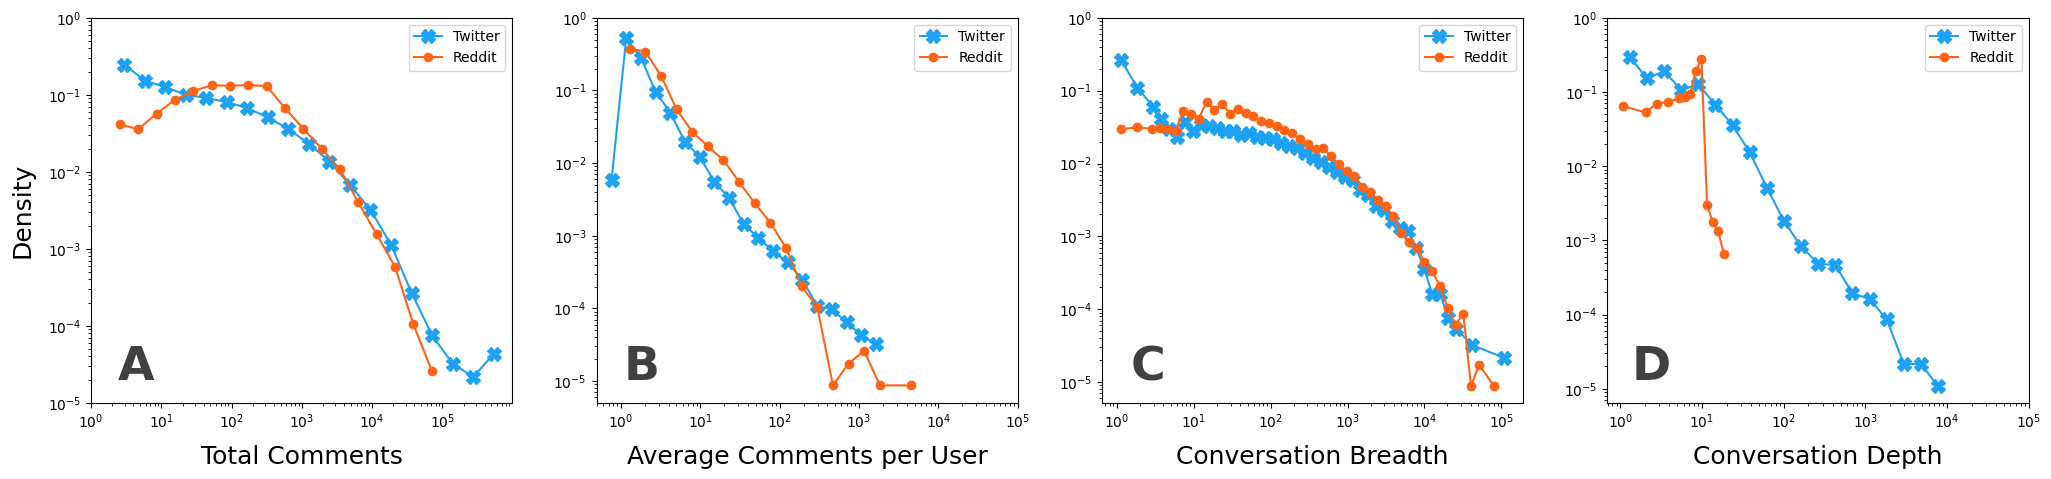

In [17]:
fig, axs = plt.subplots(nrows=1,ncols=4,
                        figsize=(25,5))

###### Box 1: Size #####

## All convos
tx, ty = binning(t_stats['size'].values, nb=20)
axs[0].loglog(tx, ty, label='Twitter', 
           color=twitter_blue, marker='X', ms=10)
rx, ry = binning(r_stats['size'].values, nb=20)
axs[0].loglog(rx, ry, label='Reddit', 
           color=reddit_orange, marker='o')

#axs[0].set_title('All Conversations', fontsize=20, pad=15)
axs[0].set_xlabel('Total Comments', fontsize=18, labelpad=10)
axs[0].set_ylabel('Density', fontsize=18, labelpad=10)

axs[0].set_yticks(np.logspace(-5, 0, 6))
axs[0].set_xticks(np.logspace(0, 5, 6))
axs[0].legend()

axs[0].text(.15, .15, 'A', transform=axs[0].transAxes,
      fontsize=34, fontweight='bold', color='#404040', 
         va='top', ha='right')



###### Box 2: Comments per user #####
## All convos
data = t_stats['size'].values / t_stats['n_users'].values
tx, ty = binning(data, nb=20)
axs[1].loglog(tx, ty, label='Twitter', 
                color=twitter_blue, marker='X', ms=10)

data = r_stats['size'].values / r_stats['n_users'].values
rx, ry = binning(data, nb=20)
axs[1].loglog(rx, ry, label='Reddit', 
                color=reddit_orange, marker='o')

#axs[1][0].set_title('All conversations')
axs[1].set_xlabel('Average Comments per User', fontsize=18, labelpad=10)
#axs[1].set_ylabel('Density', fontsize=18, labelpad=10)

axs[1].set_yticks(np.logspace(-5, 0, 6))
axs[1].set_xticks(np.logspace(0, 5, 6))
axs[1].legend()

axs[1].text(.15, .15, 'B', transform=axs[1].transAxes,
      fontsize=34, fontweight='bold', color='#404040', 
         va='top', ha='right')


    
###### Box 3: Breadth #####
## All convos
tx, ty = binning(t_stats['breadth'].values)
axs[2].loglog(tx, ty, label='Twitter',
                 color=twitter_blue, marker='X', ms=10)

rx, ry = binning(r_stats['breadth'].values)
axs[2].loglog(rx, ry, label='Reddit', 
                color=reddit_orange, marker='o')

#axs[2][0].set_title('All conversations')
axs[2].set_xlabel('Conversation Breadth', fontsize=18, labelpad=10)
#axs[2].set_ylabel('Density', fontsize=18, labelpad=10)

axs[2].set_yticks(np.logspace(-5, 0, 6))
axs[2].set_xticks(np.logspace(0, 5, 6))
axs[2].legend()

axs[2].text(.15, .15, 'C', transform=axs[2].transAxes,
      fontsize=34, fontweight='bold', color='#404040', 
         va='top', ha='right')




###### Box 4: Depth #####
## All convos
tx, ty = binning(t_stats['depth'].values, nb=20)
axs[3].loglog(tx, ty, label='Twitter',
                 color=twitter_blue, marker='X', ms=10)

rx, ry = binning(r_stats['depth'].values, nb=20)
axs[3].loglog(rx, ry, label='Reddit',  
                 color=reddit_orange, marker='o')

#axs[3][0].set_title('All conversations')
axs[3].set_xlabel('Conversation Depth', fontsize=18, labelpad=10)
#axs[3].set_ylabel('Density', fontsize=18, labelpad=10)

axs[3].set_yticks(np.logspace(-5, 0, 6))
axs[3].set_xticks(np.logspace(0, 5, 6))
axs[3].legend()

axs[3].text(.15, .15, 'D', transform=axs[3].transAxes,
      fontsize=34, fontweight='bold', color='#404040', 
         va='top', ha='right')

plt.savefig('figs/dists.png', dpi=300,
             bbox_inches='tight')

plt.show()

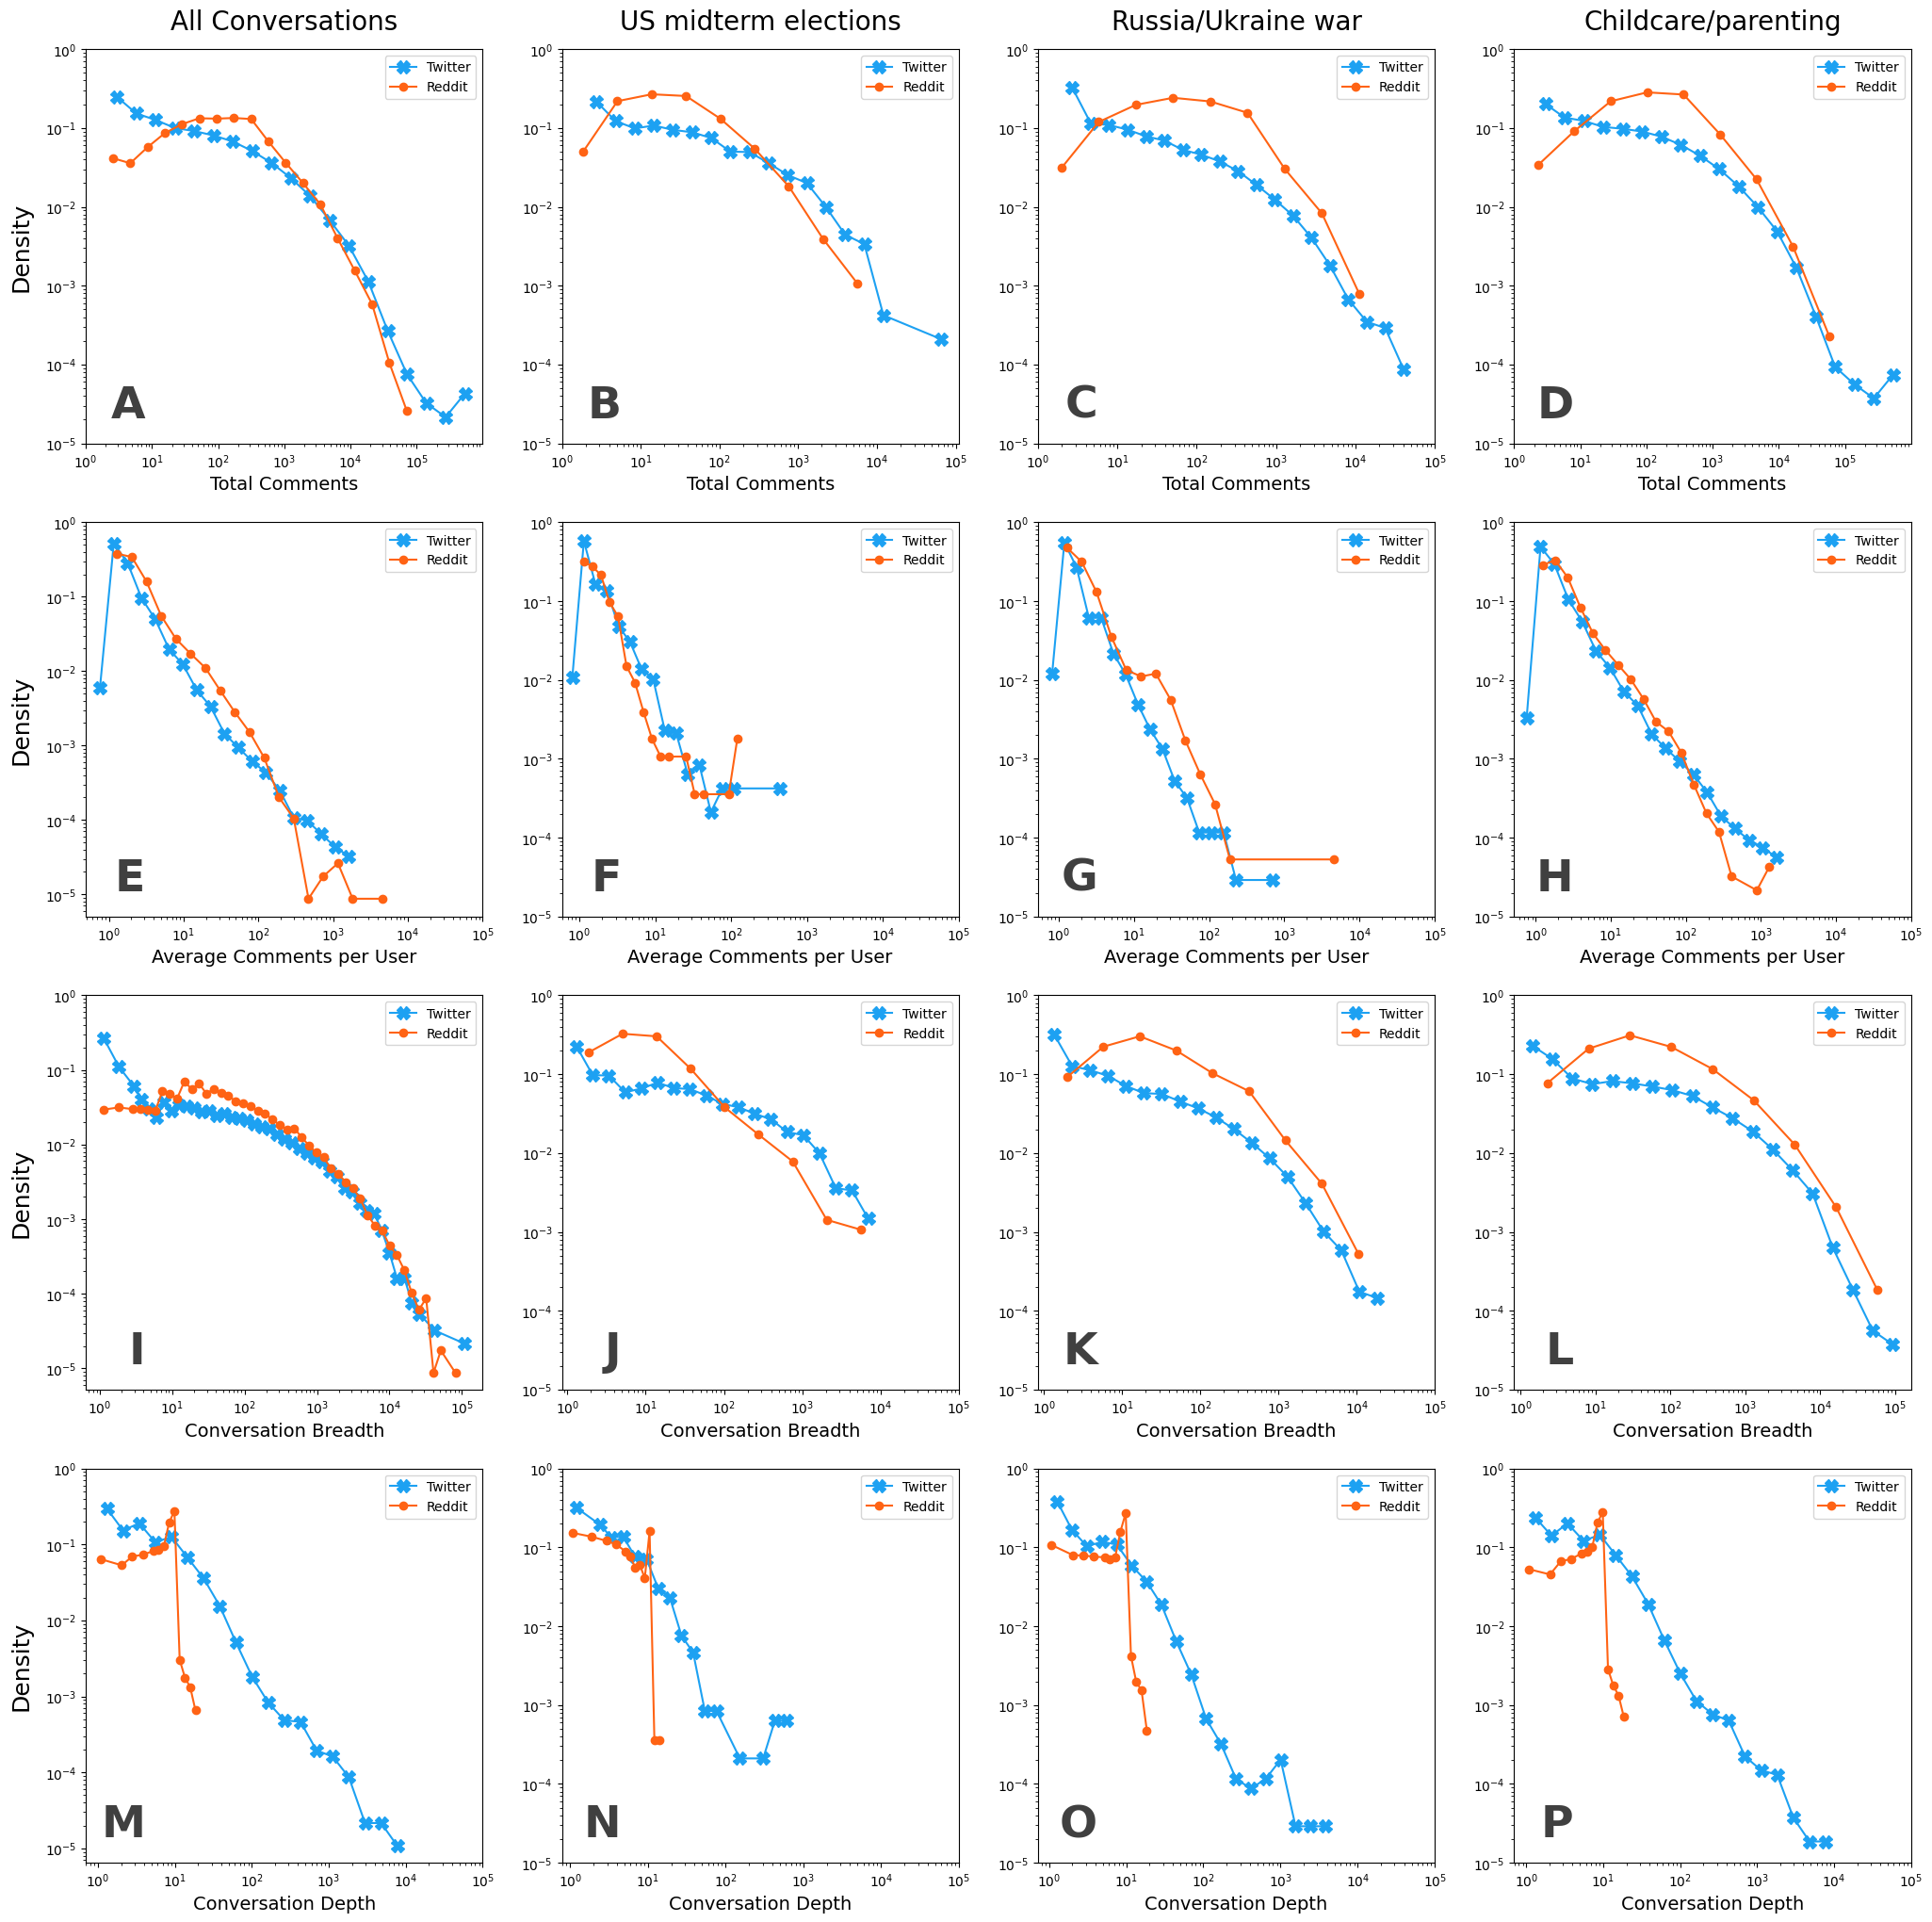

In [18]:
fig, axs = plt.subplots(nrows=4,ncols=4,
                        figsize=(25,25))

###### Row 1: Size #####

## All convos
tx, ty = binning(t_stats['size'].values, nb=20)
axs[0][0].loglog(tx, ty, label='Twitter', 
           color=twitter_blue, marker='X', ms=10)
rx, ry = binning(r_stats['size'].values, nb=20)
axs[0][0].loglog(rx, ry, label='Reddit', 
           color=reddit_orange, marker='o')

axs[0][0].set_title('All Conversations', fontsize=20, pad=15)
axs[0][0].set_xlabel('Total Comments', fontsize=14)
axs[0][0].set_ylabel('Density', fontsize=18, labelpad=10)

axs[0][0].set_yticks(np.logspace(-5, 0, 6))
axs[0][0].set_xticks(np.logspace(0, 5, 6))
axs[0][0].legend()

axs[0][0].text(.15, .15, 'A', transform=axs[0][0].transAxes,
      fontsize=34, fontweight='bold', color='#404040', 
         va='top', ha='right')

## By topic
for i, topic in enumerate(topics):
    t_sub = t_stats[t_stats['classified_topic']==topic]              
    tx, ty = binning(t_sub['size'].values, nb=20)
    axs[0][i+1].loglog(tx, ty, label='Twitter', 
               color=twitter_blue, marker='X', ms=10)
    
    r_sub = r_stats[r_stats['classified_topic']==topic]      
    rx, ry = binning(r_sub['size'].values, nb=10)
    axs[0][i+1].loglog(rx, ry, label='Reddit',
               color=reddit_orange, marker='o')

    axs[0][i+1].set_title(f'{topic}', fontsize=20, pad=15)
    axs[0][i+1].set_xlabel('Total Comments', fontsize=14)
    # axs[0][i+1].set_ylabel('Density')

    axs[0][i+1].set_yticks(np.logspace(-5, 0, 6))
    axs[0][i+1].set_xticks(np.logspace(0, 5, 6))
    axs[0][i+1].legend()
    
    letters = {0: 'B',
               1: 'C',
               2: 'D'}
    
    axs[0][i+1].text(.15, .15, letters[i], transform=axs[0][i+1].transAxes,
      fontsize=34, fontweight='bold', color='#404040', 
         va='top', ha='right')


###### Row 2: Comments per user #####
## All convos
data = t_stats['size'].values / t_stats['n_users'].values
tx, ty = binning(data, nb=20)
axs[1][0].loglog(tx, ty, label='Twitter', 
                color=twitter_blue, marker='X', ms=10)

data = r_stats['size'].values / r_stats['n_users'].values
rx, ry = binning(data, nb=20)
axs[1][0].loglog(rx, ry, label='Reddit', 
                color=reddit_orange, marker='o')

#axs[1][0].set_title('All conversations')
axs[1][0].set_xlabel('Average Comments per User', fontsize=14)
axs[1][0].set_ylabel('Density', fontsize=18, labelpad=10)

axs[1][0].set_yticks(np.logspace(-5, 0, 6))
axs[1][0].set_xticks(np.logspace(0, 5, 6))
axs[1][0].legend()

axs[1][0].text(.15, .15, 'E', transform=axs[1][0].transAxes,
      fontsize=34, fontweight='bold', color='#404040', 
         va='top', ha='right')

## By topics
for i, topic in enumerate(topics):
    t_sub = t_stats[t_stats['classified_topic']==topic]
    data = t_sub['size'].values / t_sub['n_users'].values
        
    tx, ty = binning(data, nb=20)
    axs[1][i+1].loglog(tx, ty, label='Twitter', 
                color=twitter_blue, marker='X', ms=10)
    
    r_sub = r_stats[r_stats['classified_topic']==topic]  
    data = r_sub['size'].values / r_sub['n_users'].values
    rx, ry = binning(data, nb=20)
    axs[1][i+1].loglog(rx, ry, label='Reddit',  
                color=reddit_orange, marker='o')

#    axs[1][i+1].set_title(f'{topic}')
    axs[1][i+1].set_xlabel('Average Comments per User', fontsize=14)
#    axs[1][i+1].set_ylabel('Density')

    axs[1][i+1].set_yticks(np.logspace(-5, 0, 6))
    axs[1][i+1].set_xticks(np.logspace(0, 5, 6))
    axs[1][i+1].legend()
    
    letters = {0: 'F',
               1: 'G',
               2: 'H'}
    
    axs[1][i+1].text(.15, .15, letters[i], transform=axs[1][i+1].transAxes,
      fontsize=34, fontweight='bold', color='#404040', 
         va='top', ha='right')
    
###### Row 3: Breadth #####
## All convos
tx, ty = binning(t_stats['breadth'].values)
axs[2][0].loglog(tx, ty, label='Twitter',
                 color=twitter_blue, marker='X', ms=10)

rx, ry = binning(r_stats['breadth'].values)
axs[2][0].loglog(rx, ry, label='Reddit', 
                color=reddit_orange, marker='o')

#axs[2][0].set_title('All conversations')
axs[2][0].set_xlabel('Conversation Breadth', fontsize=14)
axs[2][0].set_ylabel('Density', fontsize=18, labelpad=10)

axs[2][0].set_yticks(np.logspace(-5, 0, 6))
axs[2][0].set_xticks(np.logspace(0, 5, 6))
axs[2][0].legend()

axs[2][0].text(.15, .15, 'I', transform=axs[2][0].transAxes,
      fontsize=34, fontweight='bold', color='#404040', 
         va='top', ha='right')

## By topics
for i, topic in enumerate(topics):
    t_sub = t_stats[t_stats['classified_topic']==topic]              
    tx, ty = binning(t_sub['breadth'].values, nb=20)
    axs[2][i+1].loglog(tx, ty, label='Twitter', 
               color=twitter_blue, marker='X', ms=10)
    
    r_sub = r_stats[r_stats['classified_topic']==topic]    
    rx, ry = binning(r_sub['breadth'].values, nb=10)
    axs[2][i+1].loglog(rx, ry, label='Reddit',
               color=reddit_orange, marker='o')

#    axs[2][i+1].set_title(f'{topic_dict[topic]}')
    axs[2][i+1].set_xlabel('Conversation Breadth', fontsize=14)
#    axs[2][i+1].set_ylabel('Density')

    axs[2][i+1].set_yticks(np.logspace(-5, 0, 6))
    axs[2][i+1].set_xticks(np.logspace(0, 5, 6))
    axs[2][i+1].legend()
    
    letters = {0: 'J',
               1: 'K',
               2: 'L'}
    
    axs[2][i+1].text(.15, .15, letters[i], transform=axs[2][i+1].transAxes,
      fontsize=34, fontweight='bold', color='#404040', 
         va='top', ha='right')
    



###### Row 4: Depth #####
## All convos
tx, ty = binning(t_stats['depth'].values, nb=20)
axs[3][0].loglog(tx, ty, label='Twitter',
                 color=twitter_blue, marker='X', ms=10)

rx, ry = binning(r_stats['depth'].values, nb=20)
axs[3][0].loglog(rx, ry, label='Reddit',  
                 color=reddit_orange, marker='o')

#axs[3][0].set_title('All conversations')
axs[3][0].set_xlabel('Conversation Depth', fontsize=14)
axs[3][0].set_ylabel('Density', fontsize=18, labelpad=10)

axs[3][0].set_yticks(np.logspace(-5, 0, 6))
axs[3][0].set_xticks(np.logspace(0, 5, 6))
axs[3][0].legend()

axs[3][0].text(.15, .15, 'M', transform=axs[3][0].transAxes,
      fontsize=34, fontweight='bold', color='#404040', 
         va='top', ha='right')

## By topic
for i, topic in enumerate(topics):
    t_sub = t_stats[t_stats['classified_topic']==topic]            
    tx, ty = binning(t_sub['depth'].values, nb=20)
    axs[3][i+1].loglog(tx, ty, label='Twitter', 
               color=twitter_blue, marker='X', ms=10)
    
    r_sub = r_stats[r_stats['classified_topic']==topic]     
    rx, ry = binning(r_sub['depth'].values, nb=20)
    axs[3][i+1].loglog(rx, ry, label='Reddit',
               color=reddit_orange, marker='o')

#    axs[3][i+1].set_title(f'{topic_dict[topic]}')
    axs[3][i+1].set_xlabel('Conversation Depth', fontsize=14)
#    axs[3][i+1].set_ylabel('Density')

    axs[3][i+1].set_yticks(np.logspace(-5, 0, 6))
    axs[3][i+1].set_xticks(np.logspace(0, 5, 6))
    axs[3][i+1].legend()
    
    letters = {0: 'N',
               1: 'O',
               2: 'P'}
    
    axs[3][i+1].text(.15, .15, letters[i], transform=axs[3][i+1].transAxes,
      fontsize=34, fontweight='bold', color='#404040', 
         va='top', ha='right')

plt.savefig('figs/appendix_all_dists.png', dpi=300,
             bbox_inches='tight')

plt.show()